Cerco di capire sta cosa dei J che vengono imparati subito ma con slope sbagliata, e poi si aggiustano

In [1]:
import sys
sys.path.append('..')
import selex_dca, utils

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from utils import one_hot
import selex_dca
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

from adabmDCA.utils import init_parameters, init_chains, get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.training import train_graph

/Users/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [24]:
L, q = 3, 2

In [25]:
h = torch.zeros(L, q)
J_ = utils.rand_coupling_matrix(L, q)
potts = energy_models.Potts(J_, h)
J = J_ * potts.mask

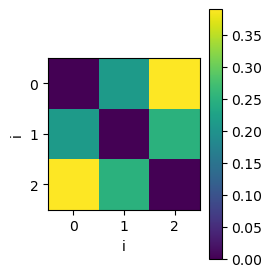

In [58]:
pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()

In [55]:
compute_energy = lambda x : potts.compute_energy(x).item()
wt_oh = one_hot(torch.randint(q, (L,)))

In [56]:
E = utils.epistasis(compute_energy, wt_oh)

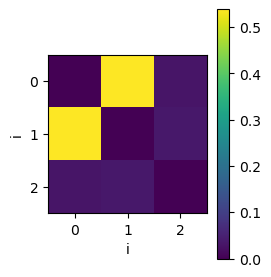

In [57]:
pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(utils.set_zerosum_gauge(E))
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()

File names for data

In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01", "R02N"]

In [3]:
device = torch.device('cpu')
dtype = torch.float32

Extract sequences and compute 1st and 2nd moment statistics

In [4]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [5]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]

In [6]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh])
fi0, _, _ = utils.frequences_from_sequences_oh(sequences_oh[0])

In [195]:
import importlib
importlib.reload(utils)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(sampling)
importlib.reload(training)
importlib.reload(callback)

<module 'callback' from '/Users/scrotti/Aptamer2025py/experiments/../callback.py'>

In [7]:
tr = tree.Tree()
tr.add_node(-1, name = "R01")
tr.add_node(0, name = "R02N")

selected_modes = torch.BoolTensor(
    [[1], [1]]
)

In [1]:
L, q = sequences_oh[0][0].shape

k = torch.zeros(L, q, dtype=dtype)
# k = torch.log(fi0)
h = torch.zeros(L, q, dtype=dtype)
J = torch.zeros(L, q, L, q, dtype=dtype)
# J = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)

ps = selex_distribution.MultiModeDistribution(potts, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

NameError: name 'sequences_oh' is not defined

In [9]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [10]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [18]:
def flattened_upper_triangular(J):
    L, q, _, _ = J.size()
    assert J.shape[2:] == (L, q)
    Jmat = J.reshape(L*q, L*q)
    idx = torch.triu_indices(*Jmat.size(), offset=q)
    return Jmat[idx[0], idx[1]]

class SaveJCallback(callback.Callback):
    def __init__(self, model = None):
        super().__init__()
        self.Js = []
        self.gradJs = []

    def after_step(self, model, **kwargs):
        potts = model.selection.modes[0]
        J = potts.J.cpu()
        gradJ = J.grad
        J = J.detach() * potts.mask.cpu().clone()
        gradJ = gradJ.clone() * potts.mask.cpu().clone()
        J = utils.set_zerosum_gauge(J)
        gradJ = utils.set_zerosum_gauge(gradJ)
        self.Js.append(flattened_upper_triangular(J))
        self.gradJs.append(flattened_upper_triangular(gradJ))

    def plot_norm(self, **kwargs):
        norm = [torch.linalg.norm(J) for J in self.Js]
        fig, ax = plt.subplots(**kwargs)
        ax.plot(norm)
        ax.set_xlabel('iter')
        ax.set_ylabel('||J||')

        return fig, ax

    def plot_pearson_slope(self, **kwargs):
        fig, axes = plt.subplots(2, **kwargs)
        Jlast = self.Js[-1]
        gradJlast = self.gradJs[-1]
        
        pearsons = [abs(1 - utils.compute_pearson(J, Jlast)) for J in self.Js]
        slopes = [abs(1 - utils.compute_slope(J, Jlast)) for J in self.Js]
        ax = axes[0]
        ax.plot(pearsons, label='|1-pearson|')
        ax.plot(slopes, label='|1-slope|')
        ax.set_yscale('log')
        ax.set_xlabel('iter')
        ax.legend()
        ax.set_title('J at iter versus J final')
        
        pearsons = [abs(1 - utils.compute_pearson(gradJ, gradJlast)) for gradJ in self.gradJs]
        slopes = [abs(1 - utils.compute_slope(gradJ, Jlast)) for gradJ in self.gradJs]
        ax = axes[1]
        ax.plot(pearsons, label='|1-pearson|')
        ax.plot(slopes, label='|1-slope|')
        ax.set_yscale('log')
        ax.set_xlabel('iter')
        ax.legend()
        ax.set_title('gradJ at iter versus J final')

        fig.tight_layout()

        return fig, ax

    def plot_scatter(self, plot_every=None, **kwargs):
        if plot_every is None:
            plot_every = len(self.Js) // 5
        n_plots = len(self.Js) // plot_every + 1
        Jlast = self.Js[-1]
        
        fig, axes = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(4, 3*n_plots), **kwargs)
        for n in range(n_plots):
            ax = axes[n]
            ax.scatter(self.Js[n*plot_every], Jlast)
            ax.plot(Jlast, Jlast, color='gray', ls='--')
            ax.set_xlabel(f'J at iter {n*plot_every}')
            ax.set_ylabel(f'J at end of train')
        fig.tight_layout()

        return fig, ax

In [19]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), SaveJCallback()]

In [ ]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 500

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs, target_pearson, 
               lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                                                                     ] Epoch: 0/500 [00…

In [ ]:
callbacks[0].plot();

In [ ]:
fig, ax = callbacks[1].plot()
ax.axhline(1, color='r', linestyle='--')

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'gradJ at iter versus J final'}, xlabel='iter'>)

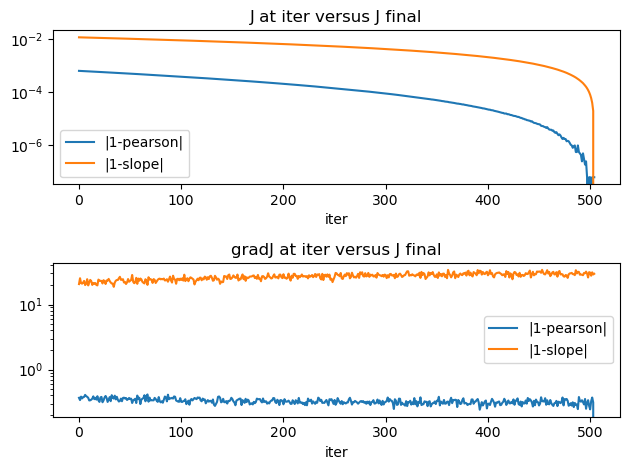

In [34]:
callbacks[2].plot_pearson_slope()

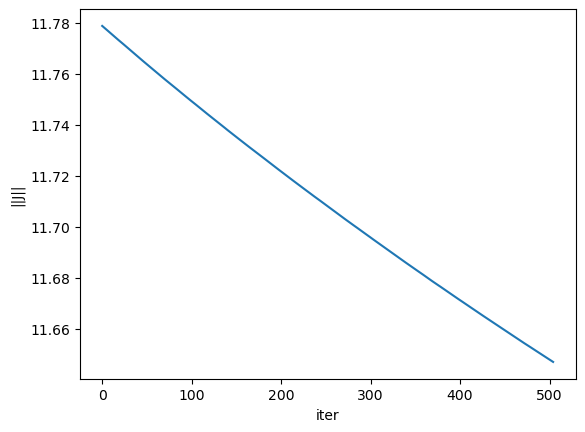

In [35]:
callbacks[2].plot_norm();

IndexError: list index out of range

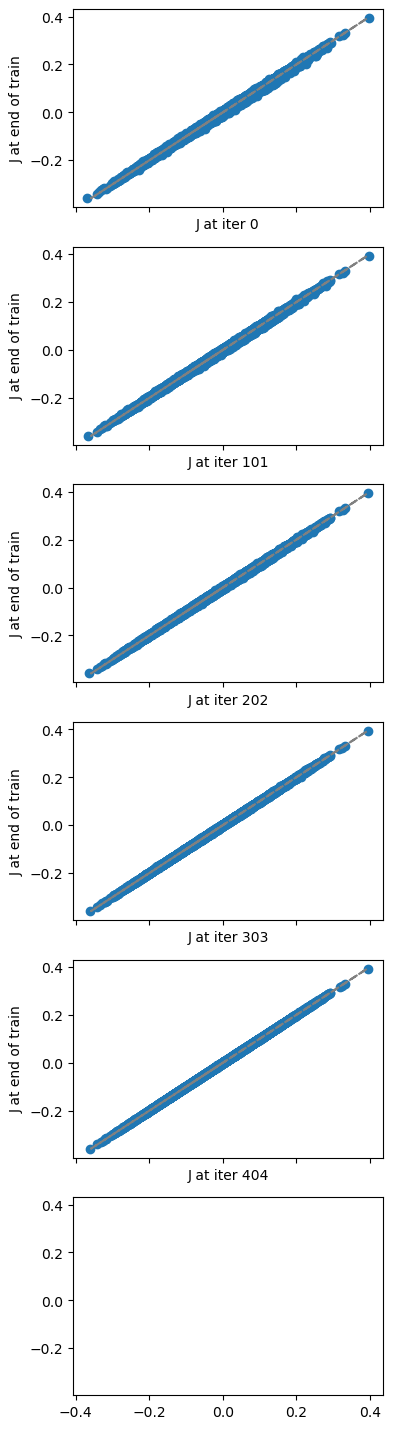

In [31]:
callbacks[2].plot_scatter()

In [ ]:
plot_every = 10
self = callbacks[2]
n_plots = len(self.Js) // plot_every + 1
Jlast = self.Js[-1]

fig, axes = plt.subplots(n_plots, sharex=True, sharey=True, figsize=(4, 3*n_plots))
for n in range(n_plots):
    ax = axes[n]
    ax.scatter(-self.gradJs[n*plot_every], Jlast)
    ax.plot(Jlast, Jlast, color='gray', ls='--')
    ax.set_xlabel(f'gradJ at iter {n*plot_every}')
    ax.set_ylabel(f'J at end of train')
fig.tight_layout()

In [ ]:
self = callbacks[2]

Jlast = self.Js[-1]
pearson = [utils.compute_pearson(-gradJ, Jlast) for gradJ in self.gradJs]
slope = [utils.compute_slope(-gradJ, Jlast) for gradJ in self.gradJs]
plt.plot(pearson)
plt.plot(slope)

In [ ]:
from IPython.display import display, Latex

potts_zerosum = potts.set_zerosum_gauge()
J = potts_zerosum.J.detach()
h = potts_zerosum.h.detach()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
print('Multi-round')

## Try to simply apply DCA to the last round

In [21]:
fi_target, fij_target, _ = utils.frequences_from_sequences_oh(sequences_oh[2], pseudo_count=0.0)

In [22]:
nchains = 10**4
sampler_alg = "gibbs"
sampler = torch.jit.script(get_sampler(sampler_alg));

In [25]:
params = init_parameters(fi=fi_target)
# params["bias"] = torch.zeros(L, q)
chains_dca = init_chains(num_chains=nchains, L=L, q=q, device=device, fi=fi_target, dtype=dtype)
# Mask for removing the autocorrelations
mask = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask[torch.arange(L), :, torch.arange(L), :] = 0
log_weights = torch.zeros(nchains, device=device, dtype=dtype)

In [26]:
target = 0.999
chains_dca, params, log_weights, history = train_graph(
    sampler=sampler,
    chains=chains_dca,
    fi_target=fi_target,
    fij_target=fij_target,
    params=params,
    mask=mask,
    log_weights=log_weights,
    nsweeps=10,
    lr=0.01,
    max_epochs=6000,
    target_pearson=target,
    )

 0.87%[3                                         ] Pearson: 0.009/0.999 [00:00]

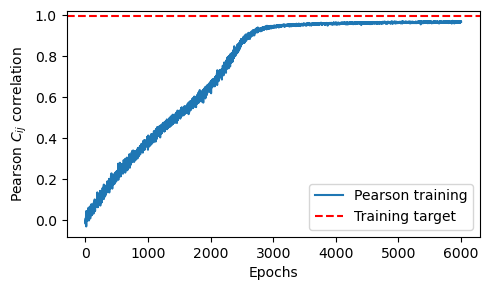

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(history["epochs"], history["pearson"], label="Pearson training")
ax.axhline(target, ls="--", color="red", label="Training target")
ax.set_xlabel("Epochs")
ax.set_ylabel(r"Pearson $C_{ij}$ correlation")
ax.legend()
fig.tight_layout()

<IPython.core.display.Latex object>

DCA on last round


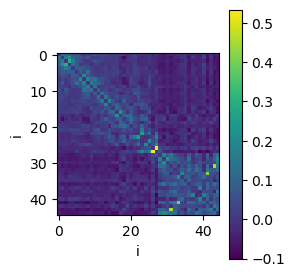

In [32]:
from IPython.display import display, Latex

J_lastround, h_lastround= utils.set_zerosum_gauge(params['coupling_matrix'], params['bias'])

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J_lastround)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))
print('DCA on last round')

0.9307611584663391

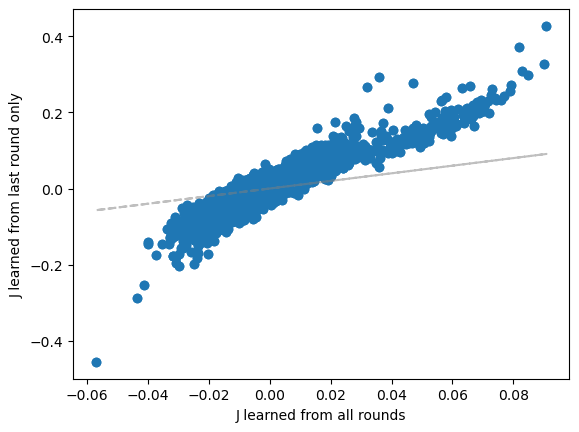

In [29]:
plt.scatter(J, J_lastround)
plt.xlabel('J learned from all rounds')
plt.ylabel('J learned from last round only')
plt.plot(J.reshape(-1), J.reshape(-1), ls='--', color='gray', alpha=0.5)
torch.corrcoef(torch.stack((J.reshape(-1), J_lastround.reshape(-1))))[0,1].item()

0.9487578272819519

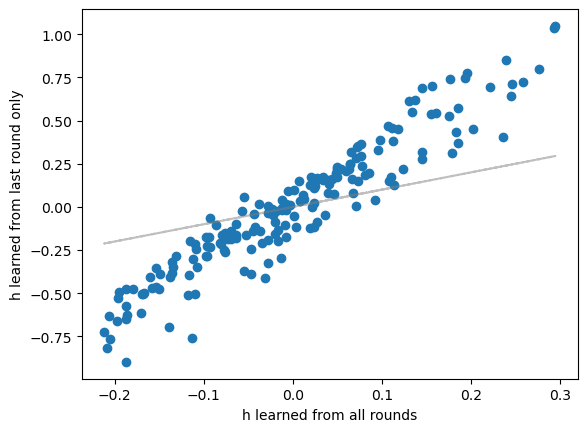

In [30]:
plt.scatter(h, h_lastround)
plt.xlabel('h learned from all rounds')
plt.ylabel('h learned from last round only')
plt.plot(h.reshape(-1), h.reshape(-1), ls='--', color='gray', alpha=0.5)
torch.corrcoef(torch.stack((h.reshape(-1), h_lastround.reshape(-1))))[0,1].item()

## PCA

In [34]:
n_sweeps = 10
n_chains = 10**5
chains_sampling = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
_ = model.sample(chains_sampling, n_sweeps)

/tmp/ipykernel_1864390/1656420050.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/home/scrotti/Aptamer2025py/.pixi/envs/default/lib/python3.12/site-packages/IPython/core/events.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/scrotti/Aptamer2025py/.pixi/envs/default/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


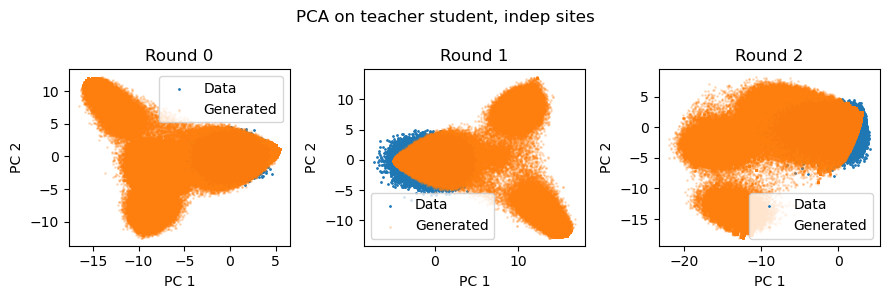

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))
markersize = 1
for t in range(n_rounds):
    pcs_data, pcs_gen = utils.compute_pca(chains_sampling[t], sequences_oh[t])
    ax = axes[t]
    idx = random.sample(range(len(pcs_data)), n_chains)
    ax.scatter(pcs_data[idx,0], pcs_data[idx,1], label='Data', s=markersize)
    ax.scatter(pcs_gen[:,0], pcs_gen[:,1], label='Generated', s=markersize, alpha=0.2)
    ax.set_xlabel('PC 1'); ax.set_ylabel('PC 2')
    ax.set_title(f'Round {t}')
    ax.legend()
fig.suptitle('PCA on teacher student, indep sites')
fig.tight_layout()